### Exploratory Analysis based on ACLED data from the Sahel region

The Sahel region includes the countries Mauritania, Mali, Burkina Faso, Chad and Niger. For this exploratory data analysis usecase data from the Armed Conflict Location & Event Data Project (ACLED); https://www.acleddata.com was used. For information concerning the methodology of ACLED can be found in: ACLED. (2019). Armed Conflict Location & Event Data Project (ACLED) Codebook, 2019. Only a subset of the data is used for this usecase including the columns "data_id", "country", "iso3", "event_type", "fatalities", "event_date" and the timeperiod from 2016-01-01 until 2021-12-31 (including). 

#### Loading libraries and data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = "./data/acled_sahel.csv"
data = pd.read_csv(path)
data = data[["data_id", "iso3", "country", "latitude", "longitude", "event_type", "fatalities"]]
data["count"] = 1

data.head()

,data_id,iso3,country,latitude,longitude,event_type,fatalities,count
0,8705857,MLI,Mali,13.9964,-3.9414,Battles,16,1
1,8706560,NER,Niger,14.4637,3.3146,Violence against civilians,0,1
2,8706884,BFA,Burkina Faso,13.8455,-1.9055,Explosions/Remote violence,0,1
3,8706897,BFA,Burkina Faso,13.7427,-1.9017,Explosions/Remote violence,0,1
4,8706980,BFA,Burkina Faso,13.8711,-2.1594,Explosions/Remote violence,0,1


#### Summarizing and Grouping

<b>Calculating and visualizing the average fatalities by country for complete timeframe</b>

In [39]:
grouped_statistic = data.groupby("country").agg(
    mean_fatalities = pd.NamedAgg(column="fatalities", aggfunc="mean"),
    median_fatalities = pd.NamedAgg(column="fatalities", aggfunc="median"),
    mode_fatalities = pd.NamedAgg(column="fatalities", aggfunc=pd.Series.mode)
)
grouped_statistic

,mean_fatalities,median_fatalities,mode_fatalities
country,,,
Burkina Faso,1.704079,0.0,0
Chad,3.562500,0.0,0
Mali,1.996070,0.0,0
Mauritania,0.014509,0.0,0
Niger,2.669078,0.0,0


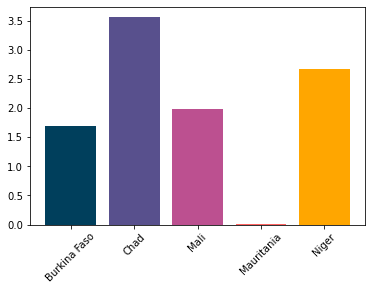

In [45]:
countries = list(grouped_statistic.index)
x_pos = np.arange(len(countries))
y = list(grouped_statistic.mean_fatalities)
color_palette = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#ffa600"]

plt.bar(x_pos, y, color=color_palette)
plt.xticks(x_pos, countries, rotation=45)
plt.show()

<b>Calculating and visualizing the dispersion of fatalities across the countries</b>

In [54]:
grouped_statistic_disp = data.groupby("country").agg(
    min_fatalities = pd.NamedAgg(column="fatalities", aggfunc=np.min),
    max_fatalities = pd.NamedAgg(column="fatalities", aggfunc="max"),
    sd_fatalities = pd.NamedAgg(column="fatalities", aggfunc=np.std),
    var_falities = pd.NamedAgg(column="fatalities", aggfunc=np.var),
    q1_fatalities = pd.NamedAgg(column="fatalities", aggfunc=lambda x: np.percentile(x, 25)),
    q2_fatalities = pd.NamedAgg(column="fatalities", aggfunc=lambda x: np.percentile(x, 50)),
    q3_fatalities = pd.NamedAgg(column="fatalities", aggfunc=lambda x: np.percentile(x, 75)),
    q4_fatalities = pd.NamedAgg(column="fatalities", aggfunc=lambda x: np.percentile(x, 100))

)
grouped_statistic_disp

,min_fatalities,max_fatalities,sd_fatalities,var_falities,q1_fatalities,q2_fatalities,q3_fatalities,q4_fatalities
country,,,,,,,,
Burkina Faso,0,160,5.624898,31.639474,0.0,0.0,1.0,160.0
Chad,0,305,15.113435,228.415906,0.0,0.0,2.0,305.0
Mali,0,157,5.382781,28.974328,0.0,0.0,2.0,157.0
Mauritania,0,2,0.152489,0.023253,0.0,0.0,0.0,2.0
Niger,0,166,9.365495,87.712499,0.0,0.0,2.0,166.0


(array([1, 2, 3, 4, 5]),
 [Text(1, 0, 'Burkina Faso'),
  Text(2, 0, 'Chad'),
  Text(3, 0, 'Mali'),
  Text(4, 0, 'Mauritania'),
  Text(5, 0, 'Niger')])

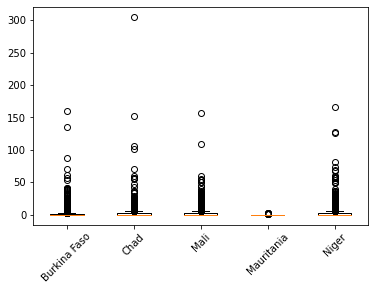

In [60]:
data_dict = {country:list(data[data["country"] == country].fatalities) for country in list(grouped_statistic_disp.index)}

fig, ax = plt.subplots()
ax.boxplot(data_dict.values())
ax.set_xticklabels(data_dict.keys())
plt.xticks(rotation=45)

From the box plot we can see that the fatalities are exceptionally scewed distributed with many outliers!